## Stacked AE and Regularization

In previous notebook we showed how a linear AE with a single hidden layer containing few units can serve as a dimension reduction method (and accordingly used for a linear feature extraction) similar to PCA. PCA can be implemented using the SVD method and when a reconstruction of the output is done from a low dimensional encoding using the few salient basis vectors, this transformation of the original input is know in the signal processing literature as Karhunen-Loeve transfrom (KLT).

In this notebook we will explore the power of AE to do more sophisticated encodings (and hopefully result in more meaningful features) by extending the linear AE in two ways:
* Add non-linear activations
* Stack multiple layers

The problem with this approach is that the number of hidden units, or number of parameters in such networks becomes very high, and the network can "memorize" the input pattern instead of finding what is significant and what is not. 
In other words, the network might not be able to generalize the data by finding a simple model, but rather will overfit the examples, which results in very poor performance when the input is different from one of the original samples that were used during training.

To overcome this difficulty, a common method of forcing the model to be "simple" is to penalize on the complexity of the weight using so call "regularization". This adds a regularization loss or complexity penalty to the overal modeling objective.

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

We will create same sin+noise signal as in the SVD notebook earlier but this time experiment with more components (you can try doing the same in linear AE or SVD to compare the results).

In [2]:
import librosa
import os

y, sr = librosa.load('./audio_files/ohm_scale.wav')
S = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))
plt.imshow(librosa.amplitude_to_db(S), origin='bottom', aspect='auto')

IOError: [Errno 20] Not a directory: '/Users/sdubnov/Documents/Courses/Mus 206 Deep & Shallow/Notebooks/Publish/audio_files/ohm_scale.wav'

In [61]:
xmat = S
print(np.shape(xmat))

(513, 447)


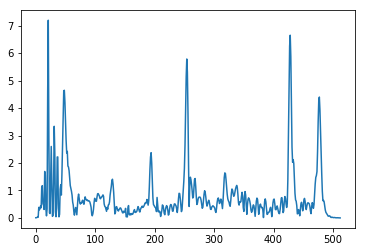

In [62]:
plt.plot(xmat[:,380])

In [323]:
n_inputs = np.shape(xmat)[0]
n_hidden1 = 100 #256 #50 
n_hidden2 = 10 #32 #10  
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01 #0.05 #0.1
l2_reg = 0.0001  #0. #0.1 

In [324]:
activation = tf.nn.elu
#activation = tf.identity
regularizer = tf.contrib.layers.l1_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = activation(tf.matmul(hidden3, weights4) + biases4)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

This is a good time also to introduce a checkpoint saving method. This will allow us to resume training if for some reason it crashed, or save the final results for later use.

In [325]:
#saver = tf.train.Saver()

In [326]:
sess = tf.InteractiveSession()
init.run()

In [327]:
n_iterations = 1000 #same as before
epoch_size = 100 # 500
n_epochs = n_iterations / epoch_size

codings = hidden2
X_train = xmat.T
X_test = X_train
    
for epoch in range(n_epochs):
    for iteration in range(epoch_size):
        _, loss_val, reconstruction_loss_val, hidden2_val = sess.run([training_op, loss, reconstruction_loss, hidden2], feed_dict={X: X_train})
        
    print loss_val, reconstruction_loss_val
    #plt.clf()
    #plt.stem(hidden2_val[-1,:])
    #plt.show(False)
    #plt.pause(0.001)

#codings_val = codings.eval(feed_dict={X: X_test})

print "Done with training"

0.303383 0.110856
0.242575 0.0938688
0.217184 0.0899385
0.205544 0.0863262
0.199228 0.0838607
0.195187 0.0828855
0.192761 0.0826598
0.190556 0.0810048
0.191392 0.0814506
0.189561 0.079795
Done with training


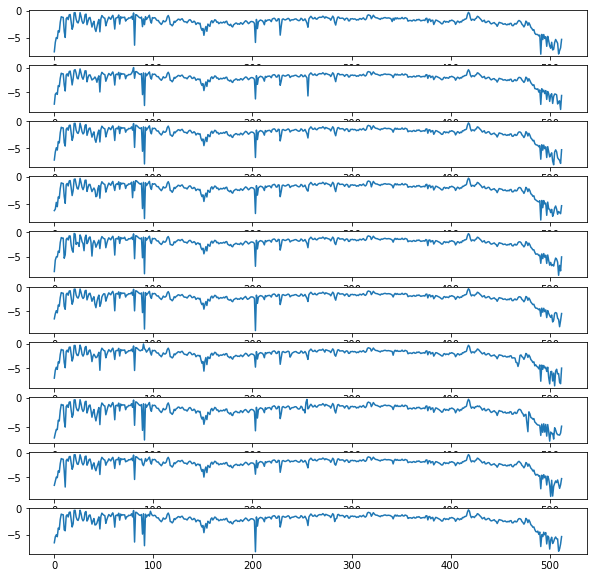

In [328]:
#activate_hidden1 = np.eye(n_hidden1,dtype = int)
activate_hidden2 = np.eye(n_hidden2,dtype = int)

#X_out1 = outputs.eval(feed_dict={hidden1: activate_hidden1})
X_out2 = outputs.eval(feed_dict={hidden2: activate_hidden2})

#plt.figure(figsize=(10, n_hidden1))
#for i in range(n_hidden1):
#    plt.subplot(n_hidden1,1,i+1)
#    plt.plot(X_out1[i].T)
    
plt.figure(figsize=(10, n_hidden2))
for i in range(n_hidden2):
    plt.subplot(n_hidden2,1,i+1)
    plt.plot(np.log(abs(X_out2[i].T)+0.0001))

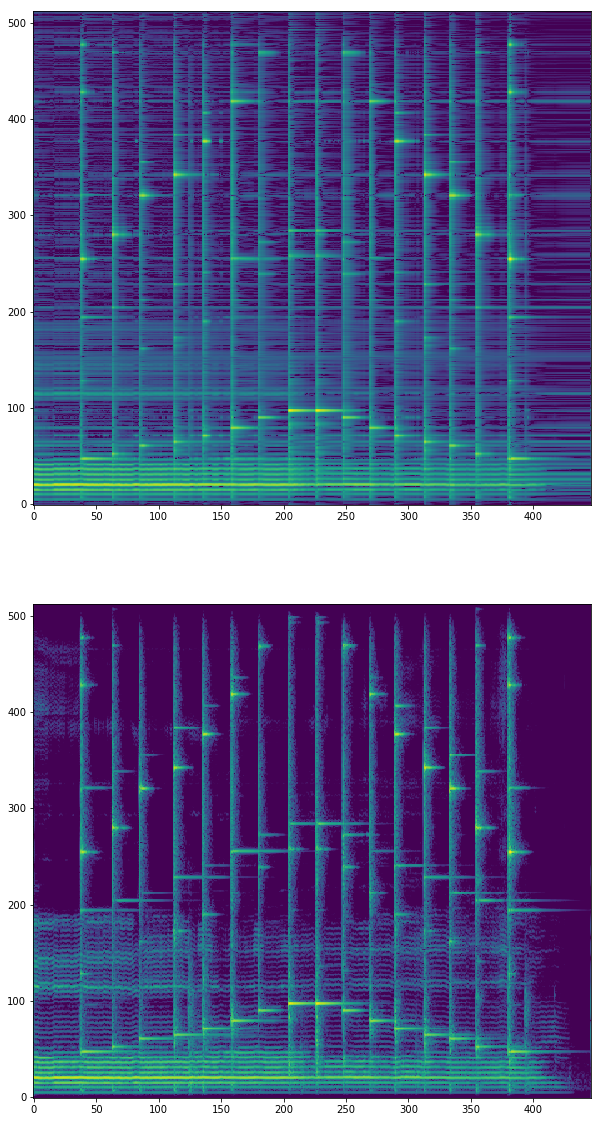

In [329]:
reconstructed_x = sess.run(outputs, feed_dict={X: X_train})
plt.figure(figsize=(10,20))
plt.subplot(211)
plt.imshow(librosa.amplitude_to_db(reconstructed_x.T), origin='bottom', aspect='auto')
plt.subplot(212)
plt.imshow(librosa.amplitude_to_db(S), origin='bottom', aspect='auto')
#librosa.amplitude_to_db(X), origin='bottom', aspect='auto')

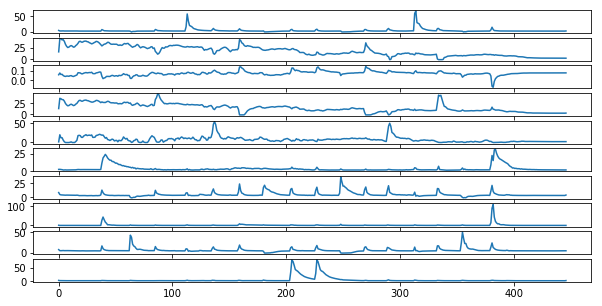

In [330]:
encodings = sess.run(hidden2, feed_dict={X: X_train})
plt.figure(figsize=(10,5))
for i in range(n_hidden2):
    plt.subplot(n_hidden2,1,i+1)
    plt.plot(encodings[:,i])

In [322]:
sess.close()